### **Importing Packages**

In [55]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 781.9 kB/s eta 0:00:0000:0100:01


In [1]:
import re
import ast
import string
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape

random.seed(42)

### **Function Utils**

In [2]:
def convert_to_int(df, int_cols):
 
    df[int_cols] = df[int_cols].apply(pd.to_numeric, errors='coerce')
    df[int_cols] = df[int_cols].fillna(-1).astype(int)
    return df


def strip_object_columns(df):
    return df.apply(lambda col: col.strip() if col.dtype == 'object' else col)


def clean_and_join(items):

    remove_punctuation = str.maketrans('', '', string.punctuation)
    cleaned_items = []
    for d in items:
        if isinstance(d, dict) and 'name' in d:
            cleaned = d['name']
            cleaned = re.sub(r'\(.*\)', '', cleaned)
            cleaned = cleaned.translate(str.maketrans('', '', string.digits))
            cleaned = cleaned.replace(' ', '')
            cleaned = cleaned.translate(remove_punctuation).lower()
            cleaned_items.append(cleaned)
    return '|'.join(cleaned_items)


def transform_columns(df, columns):

    for col in columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
        df[col] = df[col].apply(clean_and_join)

    return df


def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation.replace('|', ''))).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text



### **Load & Prepare MetaData**

In [3]:
movie_metadata = pd.read_csv('movies_metadata.csv')
movie_metadata['original_title'] = movie_metadata['original_title'].str.strip()

int_cols = ['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
movie_metadata = convert_to_int(movie_metadata, int_cols)

movie_metadata['release_date'] = pd.to_datetime(movie_metadata['release_date'], errors='coerce')
movie_metadata['years_since_release'] = (pd.Timestamp.today().year - movie_metadata['release_date'].dt.year).fillna(-1).astype(int)
movie_metadata['year'] = (movie_metadata['release_date'].dt.year).fillna(-1).astype(int)

movie_metadata = movie_metadata.loc[movie_metadata.groupby('original_title')['year'].idxmax()]


movie_metadata.drop(columns=['imdb_id', 'release_date', 'poster_path', 'genres', 'homepage', 'production_countries', 'title', 'overview'], inplace=True)
movie_metadata.info()


/tmp/ipykernel_9017/2181165777.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('movies_metadata.csv')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43373 entries, 18757 to 38352
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   adult                  43373 non-null  object
 1   belongs_to_collection  4366 non-null   object
 2   budget                 43373 non-null  int64 
 3   id                     43373 non-null  int64 
 4   original_language      43362 non-null  object
 5   original_title         43373 non-null  object
 6   popularity             43373 non-null  int64 
 7   production_companies   43371 non-null  object
 8   revenue                43373 non-null  int64 
 9   runtime                43373 non-null  int64 
 10  spoken_languages       43369 non-null  object
 11  status                 43292 non-null  object
 12  tagline                19228 non-null  object
 13  video                  43369 non-null  object
 14  vote_average           43373 non-null  int64 
 15  vote_count     

In [255]:
movie_metadata.isna().sum()

adult                        0
belongs_to_collection    40925
budget                       0
id                           0
original_language           11
original_title               0
popularity                   0
production_companies         3
revenue                      0
runtime                      0
spoken_languages             5
status                      86
tagline                  25021
video                        5
vote_average                 0
vote_count                   0
years_since_release          0
year                         0
dtype: int64

In [4]:
film_keywords = pd.read_csv('keywords.csv')
film_cast = pd.read_csv('credits.csv')

movie_metadata = pd.merge(film_keywords, movie_metadata, left_on='id', right_on='id', how='inner')
movie_metadata = pd.merge(film_cast, movie_metadata, left_on='id', right_on='id', how='inner')

movie_metadata = movie_metadata.drop_duplicates(subset=['original_title', 'year'])

sorted_cols = sorted([col for col in movie_metadata.columns if col != 'id'])
movie_metadata = movie_metadata[['id'] + sorted_cols]

In [66]:
movie_metadata.head(3)

,id,adult,belongs_to_collection,budget,cast,crew,keywords,original_language,original_title,popularity,...,revenue,runtime,spoken_languages,status,tagline,video,vote_average,vote_count,year,years_since_release
0,862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",en,Toy Story,21,...,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,False,7,5415,1995,30
1,8844,False,NaN,65000000,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",en,Jumanji,17,...,262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,False,6,2413,1995,30
2,15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",en,Grumpier Old Men,11,...,0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,False,6,92,1995,30


### **Load Films & Join MetaData**

In [5]:
movie_list = pd.read_csv('movies.csv')
movie_list['year'] = pd.to_numeric(movie_list['title'].str.extract(r'\((\d{4})\)')[0], errors='coerce').fillna(-1).astype(int)
movie_list = movie_list.loc[movie_list.groupby(movie_list['title'].str.extract(r'^(.*) \(\d{4}\)$')[0].fillna(movie_list['title']))['year'].idxmax()]
movie_list['title'] = movie_list['title'].str.replace(r'\(.*\)', '', regex=True).str.strip()

movie_list = movie_list.sort_values(by='year', ascending=False)
movie_list = movie_list.drop_duplicates(subset=['title'], keep='first')

movie_list = movie_list.sort_values(by='movieId')
movie_list.head(5)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [6]:
movie_list['title_processed'] = movie_list['title'].str.lower().str.strip().str.replace(' ', '')
movie_metadata['original_title_processed'] = movie_metadata['original_title'].str.lower().str.strip().str.replace(' ', '')

known_year = movie_list[movie_list['year'] != -1]
unknown_year = movie_list[movie_list['year'] == -1]


film_data = pd.merge(
    known_year[['movieId', 'genres', 'title_processed', 'year']],
    movie_metadata,
    left_on=['title_processed', 'year'],
    right_on=['original_title_processed', 'year'],
    how='inner'
)


fallback_merge = pd.merge(
    unknown_year[['movieId', 'genres', 'title_processed']],
    movie_metadata,
    left_on='title_processed',
    right_on='original_title_processed',
    how='inner'
)

film_data = pd.concat([film_data, fallback_merge], ignore_index=True)
film_data.drop(columns=['id', 'tagline', 'title_processed', 'year', 'original_title_processed', 'belongs_to_collection'], inplace=True)
film_data = film_data[film_data['status'] != 'Canceled']
film_data.drop([3540, 6941, 8434, 23428], axis=0, inplace=True)


In [334]:
film_data.head(3)

,movieId,title,genres,keywords,adult,budget,original_language,original_title,popularity,production_companies,revenue,runtime,spoken_languages,status,video,vote_average,vote_count,years_since_release
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",False,30000000,en,Toy Story,21,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,False,7,5415,30
1,2,Jumanji,Adventure|Children|Fantasy,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",False,65000000,en,Jumanji,17,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,False,6,2413,30
2,3,Grumpier Old Men,Comedy|Romance,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",False,0,en,Grumpier Old Men,11,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,False,6,92,30


In [23]:
film_data.columns

Index(['movieId', 'genres', 'keywords', 'adult', 'budget', 'original_language',
       'original_title', 'popularity', 'production_companies', 'revenue',
       'runtime', 'spoken_languages', 'status', 'video', 'vote_average',
       'vote_count', 'years_since_release'],
      dtype='object')

### **Preprocess Features**

In [24]:
film_data.isna().sum()

movieId                  0
genres                   0
keywords                 0
adult                    0
budget                   0
original_language        7
original_title           0
popularity               0
production_companies     0
revenue                  0
runtime                  0
spoken_languages         0
status                  43
video                    0
vote_average             0
vote_count               0
years_since_release      0
dtype: int64

In [7]:
sequence_features = ['keywords', 'production_companies', 'spoken_languages', 'cast', 'crew']
cat_cols = ['adult', 'genres', 'original_language', 'status', 'video']

film_data[['original_language', 'status']] = film_data[['original_language', 'status']].fillna('unknown')


film_data = transform_columns(film_data, sequence_features)
film_data[sequence_features] = film_data[sequence_features].replace('', 'unknown')


for cat_col in cat_cols:
    film_data[cat_col] = film_data[cat_col].astype(str)
    film_data[cat_col] = film_data[cat_col].apply(remove_punc)



In [70]:
film_data.head(10)

,movieId,genres,adult,budget,cast,crew,keywords,original_language,original_title,popularity,production_companies,revenue,runtime,spoken_languages,status,video,vote_average,vote_count,years_since_release
0,1,adventure|animation|children|comedy|fantasy,false,30000000,tomhanks|timallen|donrickles|jimvarney|wallace...,johnlasseter|josswhedon|andrewstanton|joelcohe...,jealousy|toy|boy|friendship|friends|rivalry|bo...,en,Toy Story,21,pixaranimationstudios,373554033,81,english,released,false,7,5415,30
1,2,adventure|children|fantasy,false,65000000,robinwilliams|jonathanhyde|kirstendunst|bradle...,larryjfranco|jonathanhensleigh|jameshorner|joe...,boardgame|disappearance|basedonchildrensbook|n...,en,Jumanji,17,tristarpictures|teitlerfilm|interscopecommunic...,262797249,104,english|français,released,false,6,2413,30
2,3,comedy|romance,false,0,waltermatthau|jacklemmon|annmargret|sophialore...,howarddeutch|markstevenjohnson|markstevenjohns...,fishing|bestfriend|duringcreditsstinger|oldmen,en,Grumpier Old Men,11,warnerbros|lancastergate,0,101,english,released,false,6,92,30
3,4,comedy|drama|romance,false,16000000,whitneyhouston|angelabassett|lorettadevine|lel...,forestwhitaker|ronaldbass|ronaldbass|ezraswerd...,basedonnovel|interracialrelationship|singlemot...,en,Waiting to Exhale,3,twentiethcenturyfoxfilmcorporation,81452156,127,english,released,false,6,34,30
4,5,comedy,false,0,stevemartin|dianekeaton|martinshort|kimberlywi...,alansilvestri|elliotdavis|nancymeyers|nancymey...,baby|midlifecrisis|confidence|aging|daughter|m...,en,Father of the Bride Part II,8,sandollarproductions|touchstonepictures,76578911,106,english,released,false,5,173,30
5,6,action|crime|thriller,false,60000000,alpacino|robertdeniro|valkilmer|jonvoight|toms...,michaelmann|michaelmann|artlinson|michaelmann|...,robbery|detective|bank|obsession|chase|shootin...,en,Heat,17,regencyenterprises|forwardpass|warnerbros,187436818,170,english|español,released,false,7,1886,30
6,9,action,false,35000000,jeanclaudevandamme|powersboothe|dorianharewood...,peterhyams|karenelisebaldwin|genequintano|mosh...,terrorist|hostage|explosive|vicepresident,en,Sudden Death,5,universalpictures|imperialentertainment|signat...,64350171,106,english,released,false,5,174,30
7,10,action|adventure|thriller,false,58000000,piercebrosnan|seanbean|izabellascorupco|famkej...,martincampbell|ianfleming|jeffreycaine|brucefe...,cuba|falselyaccused|secretidentity|computervir...,en,GoldenEye,14,unitedartists|eonproductions,352194034,130,english|pусский|español,released,false,6,1194,30
8,12,comedy|horror,false,0,leslienielsen|melbrooks|amyyasbeck|petermacnic...,adamweiss|melbrooks|melbrooks|melbrooks|hummie...,dracula|spoof,en,Dracula: Dead and Loving It,5,columbiapictures|castlerockentertainment|enigm...,0,88,english|deutsch,released,false,5,210,30
9,13,adventure|animation|children,false,0,kevinbacon|bobhoskins|bridgetfonda|jimcummings...,stevenspielberg|kathleenkennedy|rogershschulma...,wolf|dogsleddingrace|alaska|dog|goose|bearatta...,en,Balto,12,universalpictures|amblinentertainment|amblimation,11348324,78,english,released,false,7,423,30


### **Dataset Overview**

In [9]:
film_data.isna().sum()

movieId                 0
title                   0
genres                  0
keywords                0
adult                   0
budget                  0
original_language       0
original_title          0
popularity              0
production_companies    0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
video                   0
vote_average            0
vote_count              0
years_since_release     0
dtype: int64

In [10]:
film_data['original_title'].nunique(), film_data.shape

(23535, (23535, 18))

In [103]:
cols_to_check = ['adult', 'original_language', 'status', 'video']
unique_percentage = film_data[cols_to_check].nunique() / len(film_data)

unique_percentage


adult                0.000052
original_language    0.001955
status               0.000156
video                0.000052
dtype: float64

In [52]:
film_data['original_language'].value_counts()

en    20433
fr      650
it      460
de      367
hi      328
      ...  
bs        1
la        1
nb        1
af        1
ml        1
Name: original_language, Length: 70, dtype: int64

In [311]:
film_data['adult'].value_counts()

False    23532
True         3
Name: adult, dtype: int64

In [312]:
film_data['status'].value_counts()

Released           23318
Rumored               90
Post Production       63
In Production         11
Planned               10
Name: status, dtype: int64

In [110]:
film_data['video'].value_counts()

False    38292
True        71
Name: video, dtype: int64

In [53]:
film_data['spoken_languages'].value_counts().head(15)

english             14758
unknown              2449
français              491
english|français      359
italiano              347
english|español       342
हिन्दी                321
español               277
english|deutsch       253
deutsch               250
english|italiano      149
nolanguage            124
español|english       119
english|pусский       104
português              99
Name: spoken_languages, dtype: int64

In [54]:
film_data['keywords'].value_counts().head(15)

unknown                          7061
womandirector                     654
independentfilm                   293
standupcomedy                     197
musical                            87
sport                              73
bollywood                          43
biography                          43
suspense                           42
independentfilm|womandirector      40
christmas                          27
holiday                            23
silentfilm                         23
charliechan                        21
short                              21
Name: keywords, dtype: int64

In [55]:
film_data['production_companies'].value_counts().head(15)

unknown                               6610
metrogoldwynmayer                      493
warnerbros                             363
paramountpictures                      307
twentiethcenturyfoxfilmcorporation     274
universalpictures                      198
rkoradiopictures                       162
columbiapicturescorporation            141
columbiapictures                        89
newlinecinema                           57
universalinternationalpictures          55
waltdisneypictures                      47
tristarpictures                         46
monogrampictures                        43
touchstonepictures                      41
Name: production_companies, dtype: int64

### **Save MovieId & Dataset**

In [16]:
movie_list[(movie_list['movieId'].isin(film_data['movieId'])) & (movie_list['title'] != 'Crimewave')].to_csv('movies_subset.csv',index=False)
film_data.to_csv('film_dataset.csv',index=False)

### **Content-Based Recommendations**

In [8]:
def get_recommendations(similarity_matrix, df, movie_title=None, movie_id=None, top_n=5):

    if movie_title:
        movie_index = df[df['original_title'] == movie_title].index[0]
    else:
        movie_index = df[df['movieId'] == movie_id].index[0]
    
    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_movies = similarity_scores[1:top_n+1]
    
    recommended_movie_ids = [df.loc[i[0]]['movieId'] for i in top_movies]
    recommended_movie_titles = df[df['movieId'].isin(recommended_movie_ids)]

    recommended_movie_titles = recommended_movie_titles.copy()

    similarity_df = pd.DataFrame(similarity_scores, columns=['index', 'similarity_score']).set_index('index')
    recommended_movie_titles = recommended_movie_titles.merge(similarity_df, left_index=True, right_index=True, how='left')
    recommended_movie_titles = recommended_movie_titles.sort_values(by ='similarity_score', ascending=False)

    return recommended_movie_titles

In [9]:
features = film_data.columns.drop(['movieId', 'original_title'])

dataset = pd.DataFrame()
dataset[['movieId', 'original_title']] = film_data[['movieId', 'original_title']]
dataset['characteristic'] = film_data[features].astype(str).apply(lambda x: ' '.join(x), axis=1)

dataset = dataset.reset_index(drop=True)

In [11]:
dataset.head(5)

,movieId,original_title,characteristic
0,1,Toy Story,adventure|animation|children|comedy|fantasy fa...
1,2,Jumanji,adventure|children|fantasy false 65000000 robi...
2,3,Grumpier Old Men,comedy|romance false 0 waltermatthau|jacklemmo...
3,4,Waiting to Exhale,comedy|drama|romance false 16000000 whitneyhou...
4,5,Father of the Bride Part II,comedy false 0 stevemartin|dianekeaton|martins...


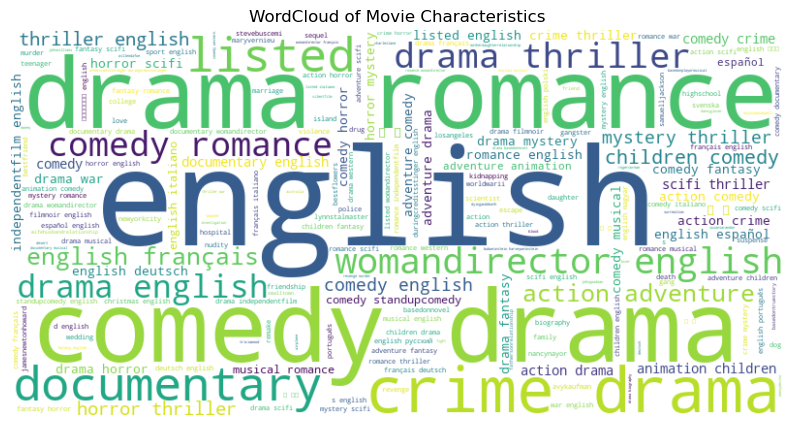

In [ ]:
text = " ".join(
    film_data[['genres', 'keywords', 'spoken_languages', 'cast', 'crew']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
)
text = text.replace('unknown', '')
text = text.replace('genres', '')


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Movie Characteristics")

output_path = 'wordcloud.png'
plt.savefig(output_path, format='png')
plt.show()


In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
feature_matrix = vectorizer.fit_transform(dataset['characteristic'])

feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 865808 stored elements and shape (23534, 253183)>

In [11]:
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)
cosine_sim.shape

(23534, 23534)

In [12]:
recommendations = get_recommendations(cosine_sim, dataset, 'Toy Story', top_n=10)
recommendations[['original_title', 'similarity_score']].reset_index(drop=True)

,original_title,similarity_score
0,Toy Story 2,0.365538
1,Toy Story 3,0.220452
2,"Monsters, Inc.",0.204398
3,WALL·E,0.179420
4,Cars,0.178888
5,Finding Nemo,0.166525
6,Boundin',0.137001
7,Presto,0.127026
8,Up,0.126707
9,Toy Story That Time Forgot,0.113704


In [13]:
recommendations = get_recommendations(cosine_sim, dataset, 'Summer Rental', top_n=10)
recommendations[['original_title', 'similarity_score']].reset_index(drop=True)

,original_title,similarity_score
0,Enter Laughing,0.094086
1,"Oh, God!",0.090654
2,Dead Men Don't Wear Plaid,0.089152
3,Tabloid,0.085765
4,Up the Academy,0.081026
5,Jonathan Livingston Seagull,0.080131
6,Green Ice,0.078733
7,Sibling Rivalry,0.076066
8,Boris and Natasha,0.074809
9,Beer,0.066452


In [18]:
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

with open('TfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

dataset.to_csv('content_based_recSys_dataset.csv',index=False)

### **Testing System**

In [12]:
def compute_predicted_rating(user_id, target_movie, df_ratings, similarity_matrix, df):

    target_movie_index = df[df['movieId'] == target_movie].index[0]
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    
    rated_movies = user_ratings['movieId'].values
    ratings = user_ratings['final_rating'].values
    
    weighted_sum = 0
    sum_of_weights = 0
    
    for i, rated_movie in enumerate(rated_movies):

        if rated_movie == target_movie:
            continue

        rated_movie_index = df[df['movieId'] == rated_movie].index[0]
        similarity = similarity_matrix[target_movie_index, rated_movie_index]
        
        weighted_sum += similarity * ratings[i]
        sum_of_weights += abs(similarity)
    
    if sum_of_weights == 0:
        return np.nan
    else:
        return weighted_sum / sum_of_weights
    

def get_liked_movies(df_ratings, threshold=3.7):

    liked_movies = df_ratings[df_ratings['final_rating'] >= threshold].groupby('userId')['movieId'].apply(set).to_dict()
    return liked_movies


def get_rated_movies(df_ratings, user_id):

    rated_movies = set(df_ratings[df_ratings['userId'] == user_id]['movieId'])
    return rated_movies


def precision_at_k(df_ratings, similarity_matrix, df, k=10, threshold=4):
  
    actual_liked_movies = get_liked_movies(df_ratings, threshold)
    precisions = []

    for user_id, liked_movies in tqdm(actual_liked_movies.items(), desc="Processing users"):
        if len(liked_movies) < 5:
            continue

        rated_movies, user_precision = get_rated_movies(df_ratings, user_id), []

        for _ in range(3):

            selected_movies = np.random.choice(list(liked_movies), 5, replace=False)
            trial_precision = []

            for movie in selected_movies:
                recommended_movies = get_recommendations(similarity_matrix, df, movie_id=movie, top_n=k)['movieId']

                relevant_count = sum(1 for rec in recommended_movies if rec in liked_movies)
                total = sum(1 for rec in recommended_movies if rec in rated_movies)
                
                if total > 0:
                    trial_precision.append(relevant_count / total)
                else:
                    continue
            
            if len(trial_precision) > 0:
                user_precision.append(np.mean(trial_precision))
            else:
                continue
        
        if len(user_precision) > 0:
            precisions.append(np.mean(user_precision))
        else:
            continue

    return np.mean(precisions) if precisions else 0.0



In [13]:
user_ratings = pd.read_csv('final_ratings_essential_columns.csv')
user_ratings = user_ratings[user_ratings['movieId'].isin(film_data['movieId'])]

user_ratings.head(5)

,userId,movieId,final_rating
1,1,25,1.0
4,1,32,5.0
5,1,34,2.0
6,1,36,1.0
8,1,110,2.0


In [19]:
print(f"Number of unique users: {user_ratings['userId'].nunique()}")
print(f"Number of unique films: {user_ratings['movieId'].nunique()}")
print(f"Total shape of the DataFrame (ratings): {user_ratings.shape}")

Number of unique users: 200944
Number of unique films: 23300
Total shape of the DataFrame (ratings): (19541553, 3)


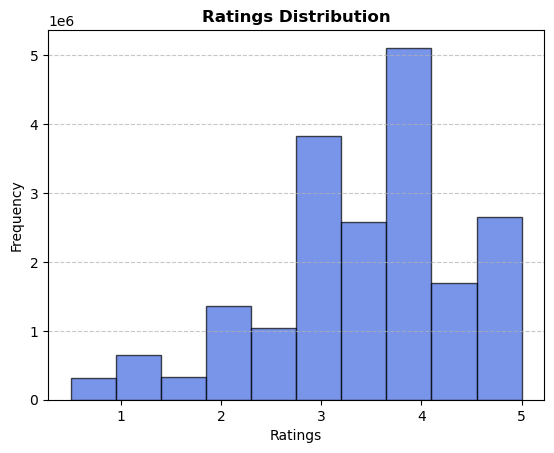

In [28]:
plt.hist(user_ratings['final_rating'], edgecolor='black', alpha=0.7, color='royalblue')  

plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Distribution', fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [27]:
user_ratings[['final_rating']].describe().astype(int)

,final_rating
count,19541553
mean,3
std,1
min,0
25%,3
50%,3
75%,4
max,5


**One User Test**

In [19]:
test_user = user_ratings['userId'].unique()[100]
predictions, actual_ratings = [], []

for target_movie in user_ratings[user_ratings['userId'] == test_user]['movieId']:
    predicted_rating = compute_predicted_rating(test_user, target_movie, user_ratings, cosine_sim, dataset)
        
    if not np.isnan(predicted_rating):
        actual_ratings.append(user_ratings[(user_ratings['userId'] == test_user) & (user_ratings['movieId'] == target_movie)]['final_rating'].values[0])
        predictions.append(predicted_rating)


# Calculate MAPE & RMSE
mape_metric, rmse_metric = mape(actual_ratings, predictions), np.sqrt(mse(actual_ratings, predictions))
print(f'RMSE: {round(rmse_metric,2)}; MAPE: {round(mape_metric*100,2)} %')

RMSE: 0.65; MAPE: 14.48 %


In [20]:
rating_sample = user_ratings[user_ratings['userId'] == 2000]

precision = precision_at_k(rating_sample, cosine_sim, dataset, k=10, threshold=4)
print(f'Precision: {round(precision,4)}')

Processing users:   0%|          | 0/1 [00:00<?, ?it/s]

Processing users: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

Precision: 0.7639


**1000 User Test**

In [15]:
np.random.seed(42)

sampled_users = np.random.choice(user_ratings['userId'].unique(), size=1000, replace=False)
sampled_df = user_ratings[user_ratings['userId'].isin(sampled_users)]

sampled_df.to_csv('test_set.csv', index=False)

print(f"Number of unique users in the sample: {sampled_df['userId'].nunique()}")
print(f"Number of unique films in the sample: {sampled_df['movieId'].nunique()}")
print(f"Total shape of the sample DataFrame (ratings): {sampled_df.shape}")

Number of unique users in the sample: 1000
Number of unique films in the sample: 5927
Total shape of the sample DataFrame (ratings): (94862, 3)


In [16]:
for test_user in tqdm(sampled_users, desc="Evaluating Users", unit="user"):
    predictions, actual_ratings = [], []

    for target_movie in user_ratings[user_ratings['userId'] == test_user]['movieId']:
        predicted_rating = compute_predicted_rating(test_user, target_movie, user_ratings, cosine_sim, dataset)
            
        if not np.isnan(predicted_rating):
            actual_ratings.append(user_ratings[(user_ratings['userId'] == test_user) & (user_ratings['movieId'] == target_movie)]['final_rating'].values[0])
            predictions.append(predicted_rating)


# Calculate MAPE & RMSE
mape_metric, rmse_metric = mape(actual_ratings, predictions), np.sqrt(mse(actual_ratings, predictions))
print(f'RMSE: {round(rmse_metric,2)}; MAPE: {round(mape_metric*100,2)} %')

Evaluating Users: 100%|██████████| 1000/1000 [3:51:49<00:00, 13.91s/user]   

RMSE: 0.65; MAPE: 15.8 %


In [22]:
precision = precision_at_k(sampled_df, cosine_sim, dataset, k=10, threshold=4)
print(f'Precision: {round(precision,4)}')

Processing users: 100%|██████████| 998/998 [07:04<00:00,  2.35it/s]

Precision: 0.6482
